In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [21]:

"""
Deterministic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
03/12/20
"""
def SIRDet(beta, gamma, mu, incubation, N, dt, I0, time):
    #all given rates per day, dt as fraction of day, e.g. dt=1 is 1 day
    #beta = average number of infective contacts per person per day
    #gamma = recovery rate per day
    #mu = death rate per day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    S = np.zeros(n) #susceptible
    E = np.zeros(n) #exposed
    I = np.zeros(n) #infected
    R = np.zeros(n) #recovered
    D = np.zeros(n) #dead
    T = np.zeros(n) #total cases, includes infected, recovered and dead
    Q = np.zeros(n) #quarantined, not currently in use
    H = np.zeros(n) #hospitalised, not currently in use
    S[0] = N - I0
    I[0] = I0
    T[0] = I[0]
    
    R0 = alpha*beta/((mu+alpha)*(mu+gamma)) #this needs reworking
    
    
    
    for i in range(1,n):
    
        S[i] = (-beta*S[i-1]*(I[i-1]+E[i-1])/N)*dt + S[i-1] 
        E[i] = (beta*S[i-1]*(I[i-1]+E[i-1])/N - alpha*E[i-1])*dt + E[i-1]
        I[i] = (alpha*E[i-1] - gamma*I[i-1] - mu*I[i-1])*dt + I[i-1]
        R[i] = (gamma*I[i-1])*dt + R[i-1]
        D[i] = (mu*I[i-1])*dt + D[i-1]
        T[i] = I[i] + R[i] + D[i]
    return{'t':t,'S':S,'E':E, 'I':I, 'R':R, 'D':D, 'Total Cases':T,'Basic Reproduction Number':R0}

In [20]:
a = np.random.binomial(999,0.95)
print(a)

961


In [33]:
"""
Stochastic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
Old - use version below with multinomial distributions for multi-exit co
03/12/20
"""


def SIRSto(beta, gamma, mu, incubation, N, dt, I0, time):
    #all given rates per day, time in days, dt as fraction of day, e.g. dt=1 is 1 day
    #beta = average number of infective contacts per person per day
    #gamma = recovery rate per day
    #mu = death rate per day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    S = np.zeros(n) #susceptible
    E = np.zeros(n) #exposed
    I = np.zeros(n) #infected
    R = np.zeros(n) #recovered
    D = np.zeros(n) #dead
    T = np.zeros(n) #total cases
    Q = np.zeros(n) #quarantined, not in use in current model
    H = np.zeros(n) #hospitlaised,  not in use in current model
    S[0] = N - I0
    I[0] = I0
    T[0] = I[0]
    
    R0 = alpha*beta/((mu+alpha)*(mu+gamma)) #this needs reworking
    
    
    for i in range(1,n):
    
        expnew = np.random.binomial(S[i-1],1-np.exp((-beta*(I[i-1]+E[i-1])/N)*dt))
        infnew = np.random.binomial(E[i-1],1-np.exp(-alpha*dt))
        recnew = np.random.binomial(I[i-1],1-np.exp(-gamma*dt))
        deadnew = np.random.binomial(I[i-1],1-np.exp(-mu*dt))
        S[i] = S[i-1] - expnew
        E[i] = E[i-1] + expnew - infnew
        I[i] = I[i-1] + infnew - recnew - deadnew
        R[i] = R[i-1] + recnew
        D[i] = D[i-1] + deadnew
        T[i] = I[i] + R[i] + D[i]
    return{'t':t,'S':S,'E':E, 'I':I, 'R':R, 'D':D, 'Total Cases':T,'Basic Reproduction Number':R0}

In [216]:
"""
Stochastic variant
Refer to https://www.aimath.org/WWN/populationmodel/chapmar25.pdf for theoretical basis
03/12/20
Add multinomial distribution for infected compartment
"""


def SIRSto(beta, gamma, mu, incubation, N, dt, I0, time):
    #all given rates per day, time in days, dt as fraction of day, e.g. dt=1 is 1 day
    t = np.arange(0,time,dt)
    n = len(t)
    alpha = 1/incubation
    S = np.zeros(n) #susceptible
    E = np.zeros(n) #exposed
    I = np.zeros(n) #infected
    R = np.zeros(n) #recovered
    D = np.zeros(n) #dead
    T = np.zeros(n) #total cases
    Q = np.zeros(n) #quarantined, not in use in current model
    H = np.zeros(n) #hospitlaised,  not in use in current model
    S[0] = N - I0
    I[0] = I0
    T[0] = I[0]
    
    R0 = alpha*beta/((mu+alpha)*(mu+gamma)) #this needs reworking
    
    
    for i in range(1,n):
    
        expnew = np.random.binomial(S[i-1],1-np.exp((-beta*(I[i-1]+E[i-1])/N)*dt))
        infnew = np.random.binomial(E[i-1],1-np.exp(-alpha*dt))
        leavinginf = np.random.multinomial(I[i-1], [1-np.exp(-gamma*dt), 1-np.exp(-mu*dt), \
        1-(1-np.exp(-gamma*dt)+1-np.exp(-mu*dt))])
        recnew = leavinginf[0]
        deadnew = leavinginf[1]
        S[i] = S[i-1] - expnew
        E[i] = E[i-1] + expnew - infnew
        I[i] = I[i-1] + infnew - recnew - deadnew
        R[i] = R[i-1] + recnew
        D[i] = D[i-1] + deadnew
        T[i] = I[i] + R[i] + D[i]
    return{'t':t,'S':S,'E':E, 'I':I, 'R':R, 'D':D, 'Total Cases':T,'Basic Reproduction Number':R0}

In [231]:
sir_out = pd.DataFrame(SIRSto(0.25, 0.1, 0.01, 2, 1000, 0.1, 1, 300))
sir_out_det = pd.DataFrame(SIRDet(0.25, 0.1, 0.01, 2, 1000, 0.01, 1, 300))

In [232]:
sir_out

,t,S,E,I,R,D,Total Cases,Basic Reproduction Number
0,0.0,999.0,0.0,1.0,0.0,0.0,1.0,2.228164
1,0.1,999.0,0.0,1.0,0.0,0.0,1.0,2.228164
2,0.2,999.0,0.0,1.0,0.0,0.0,1.0,2.228164
3,0.3,999.0,0.0,1.0,0.0,0.0,1.0,2.228164
4,0.4,999.0,0.0,1.0,0.0,0.0,1.0,2.228164
...,...,...,...,...,...,...,...,...
2995,299.5,67.0,0.0,0.0,847.0,86.0,933.0,2.228164
2996,299.6,67.0,0.0,0.0,847.0,86.0,933.0,2.228164
2997,299.7,67.0,0.0,0.0,847.0,86.0,933.0,2.228164
2998,299.8,67.0,0.0,0.0,847.0,86.0,933.0,2.228164


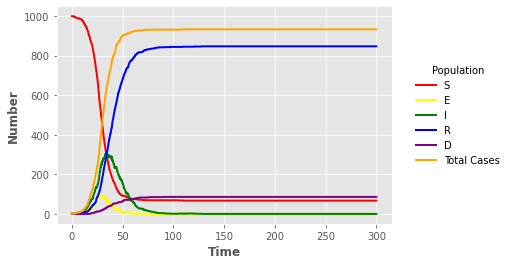

In [233]:
#stochastic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out,color="orange",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.35,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)


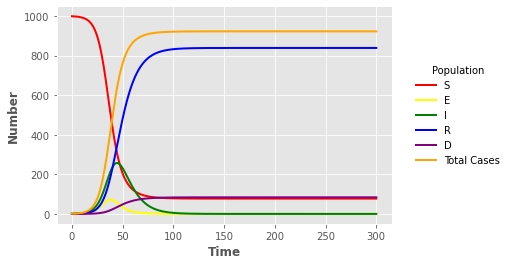

In [26]:
#deterministic
plt.style.use("ggplot")
sline = plt.plot("t","S","",data=sir_out_det,color="red",linewidth=2)
eline = plt.plot("t","E","",data=sir_out_det,color="yellow",linewidth=2)
iline = plt.plot("t","I","",data=sir_out_det,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out_det,color="blue",linewidth=2)
dline = plt.plot("t","D","",data=sir_out_det,color="purple",linewidth=2)
tline = plt.plot("t","Total Cases","",data=sir_out_det,color="orange",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.35,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

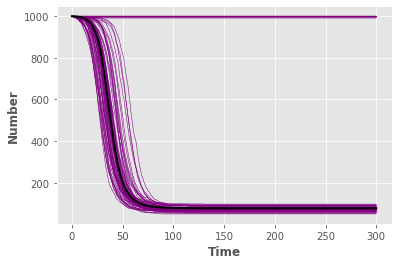

In [116]:
for i in range(0,100):
    sir_out = pd.DataFrame(SIRSto(0.25, 0.1, 0.01, 2, 1000, 0.1, 1, 300))
    plt.style.use("ggplot")
    line = plt.plot("t","S","",data=sir_out,color="purple",linewidth=0.5)
    plt.xlabel("Time",fontweight="bold")
    plt.ylabel("Number",fontweight="bold")
    

linedet = plt.plot("t","S","",data=sir_out_det,color="black",linewidth=2)



In [298]:
a = np.random.binomial(10,0.09,100)
print(a)

[1 0 1 1 0 1 2 1 1 1 1 2 2 1 2 1 1 0 0 2 1 0 1 1 1 1 1 2 3 2 1 0 1 3 1 1 1
 2 1 0 0 0 2 0 1 2 3 0 0 1 1 1 2 0 1 0 2 1 0 1 0 0 0 3 0 0 2 2 2 0 0 1 2 1
 0 0 3 0 0 1 0 1 1 0 0 1 0 0 0 4 0 1 1 1 1 0 0 0 2 2]
